# Multilayer Perceptron (MLP) for Battery Management System (BMS) SOH Estimation

<img src="../../doc/img/old_MachineLearningNetwork.png" height="1080" width="1920"
     alt="Machine Learning Network"
     style="fit: left; margin-right: 10px;"  />

# Importing Libraries

In [4]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import Activation 
from tensorflow.keras import layers, Input
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.keras.losses import MeanAbsoluteError
import plotly.express as px


# Import Data

In [5]:
# Import Data
df = pd.read_csv('../../res/model_data/batemo_model_data.csv')
df.describe()


,V,I,SOC,T_surf,SOH
count,1.640946e+06,1.640946e+06,1.640946e+06,1.640946e+06,1.640946e+06
mean,3.471013e+00,3.610140e+00,4.188879e+01,5.180549e+01,8.566437e+01
std,8.445745e-01,2.830966e+01,4.022232e+01,2.451698e+01,9.026790e+00
min,-9.394656e-01,-5.500295e+01,-5.753759e+00,2.499965e+01,7.000000e+01
25%,3.144859e+00,-1.900000e+01,1.230206e+00,2.583835e+01,7.800000e+01
50%,3.693897e+00,5.000000e+00,3.474387e+01,4.826449e+01,8.600000e+01
75%,4.064538e+00,2.600000e+01,8.456010e+01,7.304868e+01,9.400000e+01
max,4.723157e+00,5.500289e+01,1.070423e+02,1.015903e+02,1.000000e+02


# Data Preprocessing

We have to add new columns to the dataset that are the previous values of V, I and T. This will allow our model to detect the trend/gradient of the data.

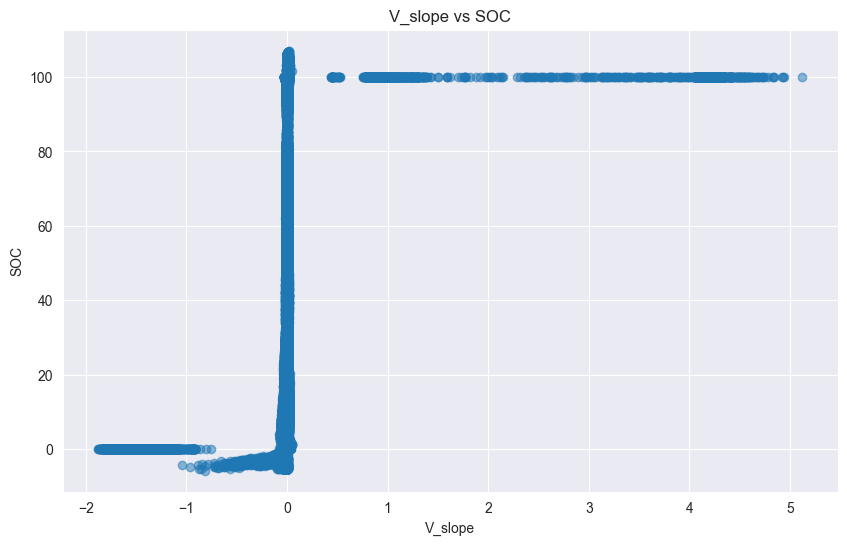

In [6]:
# Data Preprocessing
# Round the I column for simplicity
df['I_round'] = df['I'].round(0)

# Define the columns to shift
cols_to_shift = ['V', 'I', 'T_surf']

# Apply the shift to the entire dataframe, but only on each unique SOH, I Pair
for col in cols_to_shift:
    df[col + '-1'] = df.groupby(['SOH', 'I_round'])[col].shift(1)


# Drop rows with NaN values and I_round column
df = df.dropna()
df = df.drop(columns=['I_round'])

# Define training variables
X = df[['V', 'I', 'T_surf', 'V-1', 'I-1', 'T_surf-1']]
Y = df[['SOH']]

# define the slopes 
df['V_slope'] = (df['V'] - df['V-1'])/1
V_slope = df['V_slope']

# Normalize the input data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# df

# plot a scatter plot of voltage vs temperature
# fig = px.scatter_matrix(df)
# fig.show()

# Plot V_slope versus SOC
# plt.figure(figsize=(10, 6))
# plt.scatter(V_slope, df['SOC'], alpha=0.5)
# plt.title('V_slope vs SOC')
# plt.xlabel('V_slope')
# plt.ylabel('SOC')
# plt.grid(True)
# plt.show()


# Model Training

In [19]:
# Model Training with regularization and dropout
# model = Sequential([
#     # input layer
#     Input(shape=(6, )),
#
#     # dense layer 1 with L1 regularization
#     Dense(256, activation='sigmoid', kernel_regularizer=l1(0.01)),
#
#     # dropout layer
#     Dropout(0.5),
#
#     # dense layer 2 with L2 regularization
#     Dense(128, activation='sigmoid', kernel_regularizer=l2(0.01)),
#
#     # dropout layer
#     Dropout(0.5),
#
#     # output layer
# #     Dense([70, 100], activation='relu'),
# # ])
#
#     # output layer with linear activation
#     Dense(1, activation='linear'),
# ])

# Define the architecture of the MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])


# OLD Model Testing (commented out code)

In [20]:
# Model Testing
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.compile(optimizer=Adam(learning_rate=0.3),
#               loss='mean_squared_error',  # Use mean squared error for regression
#               metrics=['mse'])

# define training variables V, I, and T here: 
# X = df[['V', 'I', 'T_surf', 'V-1', 'I-1', 'T_surf-1']]
# Y = df[['SOH']]

# Scale the output variable to [0, 1]
# scaler = MinMaxScaler(feature_range=(0, 100))
# Y_scaled = scaler.fit_transform(Y)

# Normalize the input data
# scaler = MinMaxScaler()
# X_normalized = scaler.fit_transform(X)

# split up the data into training and testing 
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# model.fit(x_train, y_train, epochs=10,
# 		batch_size=2000,
# 		validation_split=0.2)
#
# results = model.evaluate(x_test, y_test, verbose = 0)
# print('test loss, test mse:', results)


# # Define a custom learning rate
# custom_learning_rate = 0.001  # Adjust this value as needed
# 
# # Create an instance of the Adam optimizer with the custom learning rate
# custom_adam_optimizer = Adam(learning_rate=custom_learning_rate)
# 
# # Compile the model with the custom Adam optimizer
# model.compile(optimizer=custom_adam_optimizer, loss='mean_squared_error')



# New Model Testing using Adam as optimizier, MSE and MAE to measure performance

In [21]:
# Define custom learning rates
adam_learning_rate = 0.03 # default learning rate for Adam in Keras is 0.001

# Compile the model with Adam optimizer and custom learning rate
adam_optimizer = Adam(learning_rate=adam_learning_rate)

# Compile the model
# model.compile(optimizer=Adam(), loss='mean_squared_error')
model.compile(optimizer=adam_optimizer, loss='mean_squared_error') # use custom learning rate to see if this improves performance 
# we are using Adam as the optimizer as opposed to using SGD 
# Adam typically offers faster convergence and better performance but requires tuning its hyperparameters


# Train the model
# history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.1)
history_adam = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

# Evaluate the model
# loss = model.evaluate(x_test, y_test)
# print("Test Loss:", loss)
loss_adam = model.evaluate(x_test, y_test)
print("Test Loss (Adam):", loss_adam)

# Compile the model with MAE loss for Adam optimizer
model.compile(optimizer=Adam(), loss=MeanAbsoluteError())

# Evaluate the model using MAE for Adam optimizer
mae_adam = model.evaluate(x_test, y_test)
print("MAE (Adam):", mae_adam)

# TODO: add additional metrics such as MAE to make sure the model will perform fine on unseen data 
# Compile the model with MAE loss
# model.compile(optimizer=Adam(), loss=MeanAbsoluteError())
# 
# # Evaluate the model using MAE
# mae = model.evaluate(x_test, y_test)
# print("MAE:", mae)
# 
# model_using_SGD.compile(optimizer=sgd_optimizer, loss=MeanAbsoluteError())
# 
# # Evaluate the model using MAE
# mae = model_using_SGD.evaluate(x_test, y_test)
# print("MAE:", mae)


# NOTE: after re-running the model multiple times, the accuracy seems to "improve" 
# this is due to the learned weights for theta after each run, making the model seem more accurate

Epoch 1/50
36844/36844 [==============================] - 58s 2ms/step - loss: 62.7960 - val_loss: 38.4160
Epoch 2/50
36844/36844 [==============================] - 59s 2ms/step - loss: 40.6630 - val_loss: 36.4122
Epoch 3/50
36844/36844 [==============================] - 60s 2ms/step - loss: 38.1702 - val_loss: 35.2494
Epoch 4/50
36844/36844 [==============================] - 62s 2ms/step - loss: 37.0476 - val_loss: 37.2267
Epoch 5/50
36844/36844 [==============================] - 64s 2ms/step - loss: 36.5136 - val_loss: 35.1959
Epoch 6/50
36844/36844 [==============================] - 64s 2ms/step - loss: 36.2103 - val_loss: 35.9959
Epoch 7/50
36844/36844 [==============================] - 64s 2ms/step - loss: 35.9092 - val_loss: 35.8242
Epoch 8/50
36844/36844 [==============================] - 64s 2ms/step - loss: 35.6906 - val_loss: 35.2146
Epoch 9/50
36844/36844 [==============================] - 64s 2ms/step - loss: 35.6533 - val_loss: 35.9705
Epoch 10/50
36844/36844 [============

# Add a model that uses SGD as the optimizier to compare performance with the Adam optimizier

In [ ]:
# Add second model using SGD as the optimizer to see if one out-performs the other 
sgd_learning_rate = 0.03 # default learning rate for SGD is 0.01

# Custom SGD optimizer with learning rate of 0.01 and momentum of 0.9
# sgd_optimizer = SGD(lr=0.01, momentum=0.9)
# 
# # Compile the model using the custom SGD optimizer
# model_using_SGD.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

# Compile the model with SGD optimizer and custom learning rate
sgd_optimizer = SGD(lr=sgd_learning_rate, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

# Train the model with SGD optimizer
history_sgd = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

# Evaluate the model trained with SGD optimizer
loss_sgd = model.evaluate(x_test, y_test)
print("Test Loss (SGD):", loss_sgd)

# Compile the model with MAE loss for SGD optimizer
model.compile(optimizer=sgd_optimizer, loss=MeanAbsoluteError())

# Evaluate the model using MAE for SGD optimizer
mae_sgd = model.evaluate(x_test, y_test)
print("MAE (SGD):", mae_sgd)

# Model Export

In [4]:
# Model Export
# save Keras model
model.save("model_file_name" +'.h5')
# convert Keras model to a tflite model 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
with open("model_file_name" + '.tflite', 'wb') as f:
    f.write(tflite_model)
	